In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, SimpleRNN, Conv1D, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adagrad, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import numpy as np


In [100]:
config = dict(
    samples=1000,
    features=20,
    informative=15,
    classes=5,
    test_size=0.2,
    random_state=42,
    activations=['relu', 'tanh', 'sigmoid', 'elu', 'softmax'],
)

In [101]:
X, y = make_classification(
    n_samples=config['samples'],
    n_features=config['features'],
    n_informative=config['informative'],
    n_redundant=config['features'] - config['informative'],
    n_classes=config['classes'],
    random_state=config['random_state'],
    weights=[1 / config['classes']] * config['classes'],
)
X = X.astype(np.float32)
y = to_categorical(y, num_classes=5)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=config['test_size'],
    random_state=config['random_state'],
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [157]:
def create_rnn_model(activation='tanh'):
    model = Sequential()
    model.add(GRU(64, activation=activation, return_sequences=True, input_shape=(X_train_rnn.shape[1], 1)))
    model.add(GRU(64, activation=activation, return_sequences=True))
    model.add(SimpleRNN(32, activation=activation, return_sequences=True))
    model.add(SimpleRNN(32, activation=activation, return_sequences=True))
    model.add(GRU(16, activation=activation, return_sequences=True))
    model.add(GRU(16, activation=activation, return_sequences=False))
    model.add(Dense(5, activation='softmax'))
    model.compile(
        optimizer=Adagrad(learning_rate=0.01),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy'],
    )
    return model

In [159]:
def create_cnn_model():
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [158]:
results_rnn = {}

for act in config['activations']:
    model = create_rnn_model(act)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train_rnn, y_train,
                        epochs=100,
                        batch_size=128,
                        validation_split=0.2,
                        callbacks=[early_stop],
                        verbose=1)
    history = model.fit(X_train_rnn, y_train, epochs=10, batch_size=32, validation_split=0.2)
    test_loss, test_acc = model.evaluate(X_test_rnn, y_test, verbose=0)
    results_rnn[act] = test_acc

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 325ms/step - categorical_accuracy: 0.1907 - loss: 1.6096 - val_categorical_accuracy: 0.2062 - val_loss: 1.6093
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - categorical_accuracy: 0.2048 - loss: 1.6095 - val_categorical_accuracy: 0.1750 - val_loss: 1.6098
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - categorical_accuracy: 0.2029 - loss: 1.6084 - val_categorical_accuracy: 0.1750 - val_loss: 1.6099
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - categorical_accuracy: 0.2109 - loss: 1.6090 - val_categorical_accuracy: 0.1813 - val_loss: 1.6102
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - categorical_accuracy: 0.2230 - loss: 1.6083 - val_categorical_accuracy: 0.1813 - val_loss: 1.6104
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - categorical_accuracy: 0.2163 - loss: 1.6078 - val_categorical_accuracy: 0.1813 - val_loss: 1.6105
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - categorical_accuracy: 0.2337 - loss: 1.6062 - v

In [160]:
sorted_results = sorted(results_rnn.items(), key=lambda x: x[1], reverse=True)
sorted_results

[('elu', 0.5649999976158142),
 ('tanh', 0.5350000262260437),
 ('relu', 0.2150000035762787),
 ('sigmoid', 0.15000000596046448),
 ('softmax', 0.15000000596046448)]

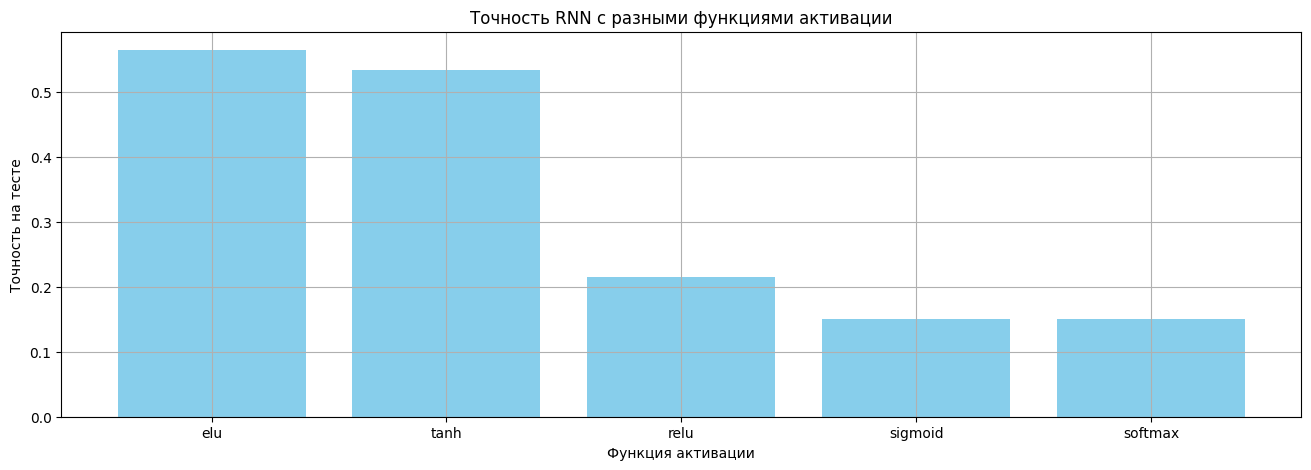

In [161]:
plt.figure(figsize=(16, 5))
plt.bar(
    [str(k) for k, _ in sorted_results],
    [k for _, k in sorted_results], 
    color='skyblue',
)
plt.xlabel('Функция активации')
plt.ylabel('Точность на тесте')
plt.title('Точность RNN с разными функциями активации')
plt.grid(True)
plt.show()

In [162]:
cnn_model = create_cnn_model()
cnn_history = cnn_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test_rnn, y_test, verbose=0)

cnn_test_acc

c:\Users\k1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


0.47999998927116394

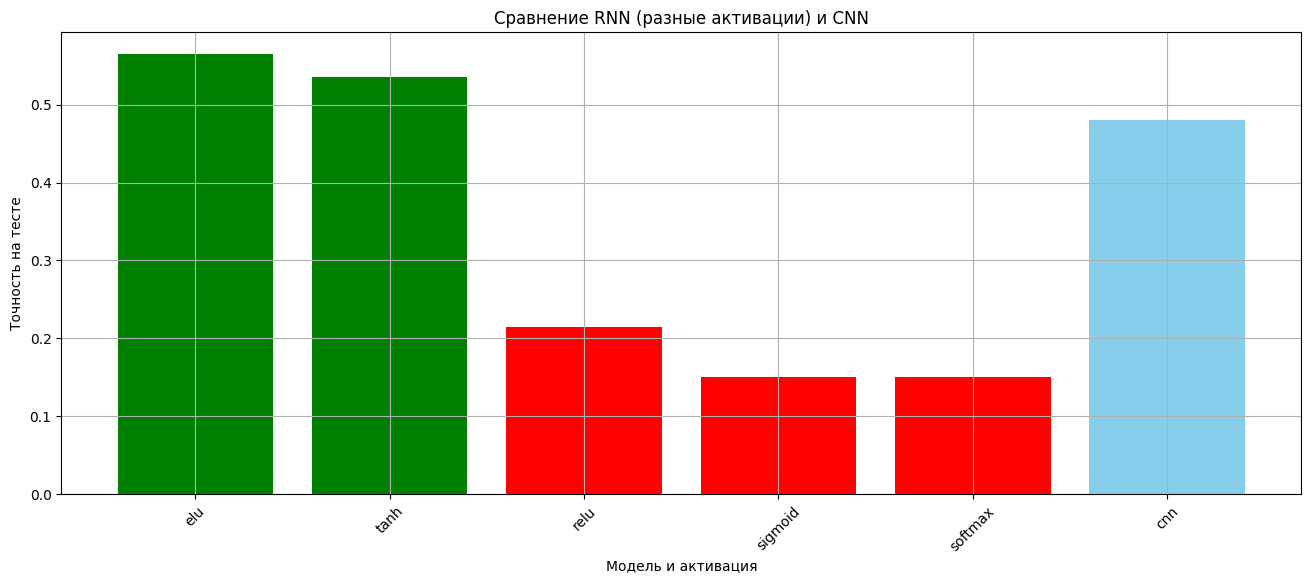

In [163]:
plt.figure(figsize=(16, 6))
plt.bar(
    [
        *[act for act, _ in sorted_results],
        'cnn',
    ],
    [
        *[k for _, k in sorted_results],
        cnn_test_acc,
    ], 
    color=[
        *[
            'green'
            if acc > cnn_test_acc
            else 'red'
            if acc < cnn_test_acc * 0.8
            else 'orange'
            for _, acc in sorted_results],
        'skyblue',
    ],
)
plt.xlabel('Модель и активация')
plt.ylabel('Точность на тесте')
plt.title('Сравнение RNN (разные активации) и CNN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [164]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

In [165]:
model = create_rnn_model()

In [167]:
model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=40,
)

y_pred = model.predict(X_test)

Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - categorical_accuracy: 0.4522 - loss: 1.3451 - val_categorical_accuracy: 0.4050 - val_loss: 1.4137
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - categorical_accuracy: 0.4576 - loss: 1.3449 - val_categorical_accuracy: 0.3800 - val_loss: 1.4002
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - categorical_accuracy: 0.4594 - loss: 1.3432 - val_categorical_accuracy: 0.3550 - val_loss: 1.3890
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - categorical_accuracy: 0.4485 - loss: 1.3243 - val_categorical_accuracy: 0.4150 - val_loss: 1.3723
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - categorical_accuracy: 0.4487 - loss: 1.3099 - val_categorical_accuracy: 0.3950 - val_loss: 1.3632
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - categorical_accuracy: 0.4593 - loss: 1.3353 - val_categorical_accuracy: 0.4100 - val_loss: 1.3732
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - categorical_accuracy: 0.4906 - loss: 1.27

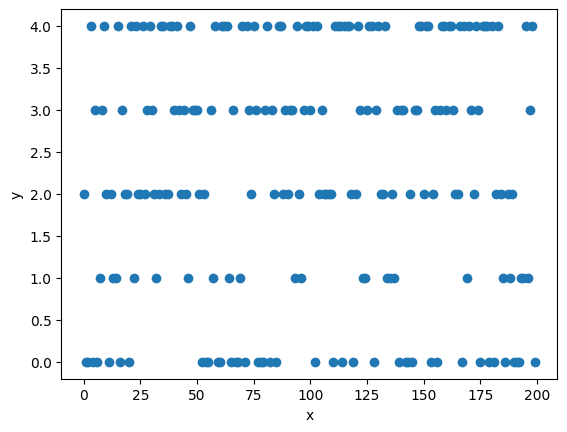

In [175]:
plt.figure()
plt.scatter(range(0, len(y_pred)), [np.argmax(i) for i in y_pred])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

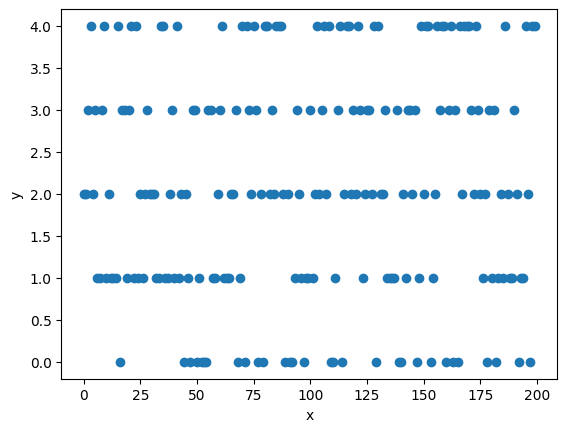

In [176]:
plt.figure()
plt.scatter(range(0, len(y_test)), [np.argmax(i) for i in y_test])
plt.xlabel('x')
plt.ylabel('y')
plt.show()